In [184]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
#import data and combine in a list, so that both sets can be processed at the same time.
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
combine = [train_df, test_df]

In [186]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [187]:
train_df.isnull().sum()
#a lot of null entry in age. Too many in Cabin!

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [188]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [189]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [190]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


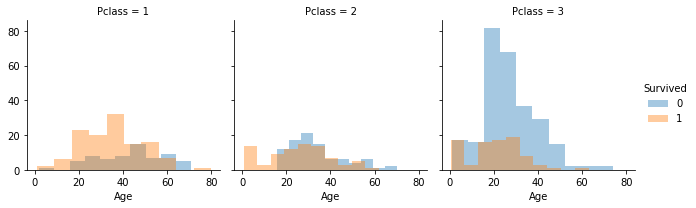

In [191]:
#visualization here
grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid.map(plt.hist, 'Age', alpha=.4, bins=10)
grid.add_legend();

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


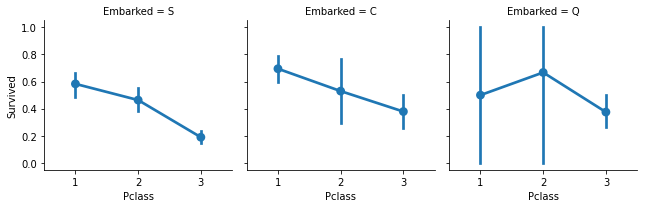

In [192]:
grid = sns.FacetGrid(train_df, col='Embarked')
#grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived')
grid.add_legend()

In [193]:
#drop a few unrelated or severely incomplete features
train_df1 = train_df.drop(['Ticket', 'Cabin','Name','PassengerId'],axis=1)
test_df1 = test_df.drop(['Ticket', 'Cabin','Name','PassengerId'],axis=1)
combine = [train_df1, test_df1]
train_df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [194]:
#convert sex string to numbers and impute data
#impute age and fare using mean and embarked using mode. 
for df in combine:
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} )
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Fare'].fillna(df['Fare'].mean(),inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0],inplace=True)



In [195]:
test_df1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,Q
1,3,1,47.0,1,0,7.0000,S
2,2,0,62.0,0,0,9.6875,Q
3,3,0,27.0,0,0,8.6625,S
4,3,1,22.0,1,1,12.2875,S


In [196]:
#convert Embark feature to number
for df in combine:
    df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q':2} ).astype(int)
    df['Age']=df['Age'].astype(int)

train_df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,0
1,1,1,1,38,1,0,71.2833,1
2,1,3,1,26,0,0,7.9250,0
3,1,1,1,35,1,0,53.1000,0
4,0,3,0,35,0,0,8.0500,0


In [197]:
# now ready to scale the data and then start modeling!
X_train=train_df1.drop(['Survived'],axis=1)
Y_train=train_df1['Survived']

from sklearn.preprocessing import StandardScaler
stds=StandardScaler()
X_train=pd.DataFrame(stds.fit_transform(X_train),index=X_train.index, columns=X_train.columns)
test_df1=pd.DataFrame(stds.fit_transform(test_df1),index=test_df1.index, columns=test_df1.columns)

In [198]:
# traing set now X_train. Test set to predict: test_df1

In [199]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [200]:
Y_predreg = logreg.predict(test_df1)

In [201]:
regscores=cross_val_score(logreg, X_train, Y_train, cv=5, scoring='roc_auc')

In [202]:
regscores.mean() 
#regression crossvalidation mean auc is 0.851

0.8506566906778665

In [203]:
#Bayes classification
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred_Gaus = gaussian.predict(test_df1)
regscores=cross_val_score(gaussian, X_train, Y_train, cv=5, scoring='roc_auc')
regscores.mean() 
#bayes classification yield auc 0.831, lower than the regression results.

0.8309066716580386

In [211]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [207]:
logreg.coef_

array([[-0.92146021,  1.28325114, -0.50709109, -0.35608979, -0.06970369,
         0.11430806,  0.15836238]])

In [ ]:
# the coefficients show Pclass, Gender and Age are most important factors affecting survival.  Gender is the most important factor.